In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey

In [2]:
# The Li Keqiang Index
file_path = r"C:\Users\hp\Favorites\Desktop\Thesis\Economic Indicator_China (Mainland) Li Keqiang index (The Economist), Chg Y_Y_15 Apr 2025.xlsx"
keqiang_index = pd.read_excel(file_path, skiprows=15, usecols="A:B", engine="openpyxl")
keqiang_index.columns = ["Date", "Keqiang Index"]
keqiang_index.set_index("Date", inplace=True)
keqiang_index.index = pd.to_datetime(keqiang_index.index)
keqiang_index.sort_index(inplace=True)

keqiang_index = keqiang_index.loc["2013-01-01":"2025-01-01"].copy()

# Calculate dynamic thresholds within the filtered date range
p25 = np.percentile(keqiang_index['Keqiang Index'], 25)
p75 = np.percentile(keqiang_index['Keqiang Index'], 75)

# Assign recession, expansion, neutral based on percentiles
keqiang_index['recession'] = (keqiang_index['Keqiang Index'] < p25).astype(int)
keqiang_index['expansion'] = (keqiang_index['Keqiang Index'] > p75).astype(int)
keqiang_index['neutral'] = ((keqiang_index['Keqiang Index'] >= p25) & 
                            (keqiang_index['Keqiang Index'] <= p75)).astype(int)

# Sort and reset index
keqiang_index.index.name = None
keqiang_index = keqiang_index.sort_index(ascending=True)

# Create an empty list to collect new rows
monthly_rows = []

# Loop through each quarterly row and expand to months
for quarter_end, row in keqiang_index.iterrows():
    start_of_quarter = quarter_end - pd.DateOffset(months=2)
    month_ends = pd.date_range(start=start_of_quarter, end=quarter_end, freq='ME')
    for month in month_ends:
        monthly_rows.append([month, *row.values])

# Create expanded monthly DataFrame
monthly_index = pd.DataFrame(monthly_rows, columns=["Date"] + keqiang_index.columns.tolist())
monthly_index.set_index("Date", inplace=True)
monthly_index.to_csv("keqiang_index.csv")


# CAPM SOEs

In [3]:
file_path = r"C:\Users\hp\Favorites\Desktop\Thesis\soes1_capm_exc.csv"
soes_capm_exc = pd.read_csv(file_path)
soes_capm_exc['Date'] = pd.to_datetime(soes_capm_exc['Date'])
soes_capm_exc.set_index('Date', inplace=True)

In [4]:
# Define rolling window size (1 year of monthly data)
window_size = 12

# Dictionaries to store beta estimates and standard errors
soes_betas = {col: [] for col in soes_capm_exc.columns if col != "exc_rmkt"}

dates = []

# Perform rolling regression
for start in range(window_size, len(soes_capm_exc)):
    window_data = soes_capm_exc.iloc[start - window_size:start]

    X = window_data["exc_rmkt"]
    X = sm.add_constant(X)

    for col in soes_capm_exc.columns:
        if col != "exc_rmkt":
            y = window_data[col]

            try:
                # Fit OLS with HAC (Newey-West)
                model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 4})
                beta = model.params["exc_rmkt"]
                beta_se = model.bse["exc_rmkt"]

                soes_betas[col].append(beta)
            except Exception as e:
                # Handle any regression failure gracefully
                soes_betas[col].append(None)
                
    dates.append(window_data.index[-1])

# Convert to DataFrame
soes_betas = pd.DataFrame(soes_betas, index=dates)

# Graph 1-Year Monthly Rolling Estimated Betas of SOEs during Recession and Expansion, measured by the Li Keqiang Index

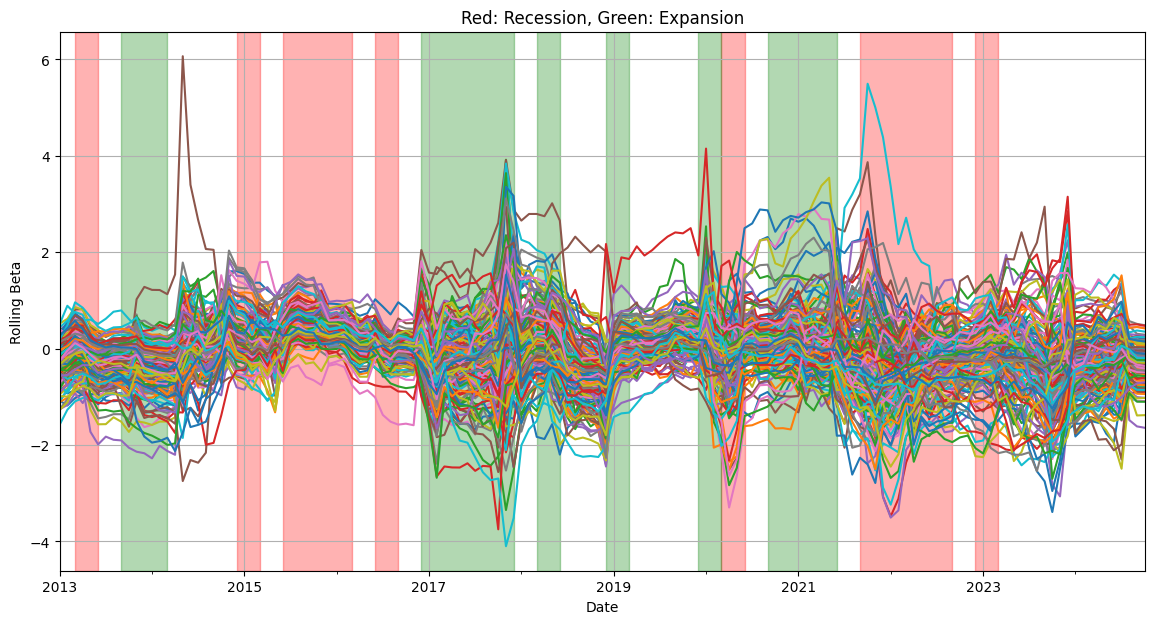

In [5]:
fig, ax = plt.subplots(figsize=(14, 7))

soes_betas.plot(ax=ax, label="5-Year Rolling Beta of SOEs")

# Shade recession periods (red):
in_recession = False
start_date_rec = None
for date, is_rec in keqiang_index['recession'].items():
    if is_rec and not in_recession:
        start_date_rec = date  # begin a new recession period
        in_recession = True
    elif not is_rec and in_recession:
        ax.axvspan(start_date_rec, date, color='red', alpha=0.3)
        in_recession = False
# Shade until the end if still in recession:
if in_recession:
    ax.axvspan(start_date_rec, keqiang_index.index[-1], color='red', alpha=0.3)
    
# Shade expansion periods (green):
in_expansion = False
start_date_exp = None
for date, is_exp in keqiang_index['expansion'].items():
    if is_exp and not in_expansion:
        start_date_exp = date  # begin a new expansion period
        in_expansion = True
    elif not is_exp and in_expansion:
        ax.axvspan(start_date_exp, date, color='green', alpha=0.3)
        in_expansion = False
# Shade until the end if still in expansion:
if in_expansion:
    ax.axvspan(start_date_exp, keqiang_index.index[-1], color='green', alpha=0.3)

# Final plot settings
ax.set_xlabel("Date")
ax.set_ylabel("Rolling Beta")
ax.set_title("Red: Recession, Green: Expansion")
ax.legend()
plt.grid(True)

ax.legend_.remove()  # Remove legend

output_path = r"C:\Users\hp\Favorites\Desktop\Thesis\Graphs\fig3.3.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

# CAPM non-SOEs

In [6]:
file_path = r"C:\Users\hp\Favorites\Desktop\Thesis\nsoes1_capm_exc.csv"
nsoes_capm_exc = pd.read_csv(file_path)
nsoes_capm_exc['Date'] = pd.to_datetime(nsoes_capm_exc['Date'])
nsoes_capm_exc.set_index('Date', inplace=True)

In [7]:
# Define rolling window size (1 years of monthly data)
window_size = 12

# Initialize dictionaries to store betas and standard errors
nsoes_betas = {col: [] for col in nsoes_capm_exc.columns if col != "exc_rmkt"}

dates = []

# Rolling regression with HAC standard errors
for start in range(window_size, len(nsoes_capm_exc)):
    window_data = nsoes_capm_exc.iloc[start - window_size:start]
    X = sm.add_constant(window_data["exc_rmkt"])

    for col in nsoes_capm_exc.columns:
        if col != "exc_rmkt":
            y = window_data[col]

            try:
                # Fit with HAC (Newey-West) standard errors
                model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 4})
                beta = model.params["exc_rmkt"]
                beta_se = model.bse["exc_rmkt"]

                nsoes_betas[col].append(beta)
            except Exception as e:
                nsoes_betas[col].append(None)

    dates.append(window_data.index[-1])

# Convert to DataFrames
nsoes_betas = pd.DataFrame(nsoes_betas, index=dates)

# Graph 1-Year Monthly Rolling Estimated Betas of non-SOEs during Recession and Expansion, measured by the Li Keqiang Index

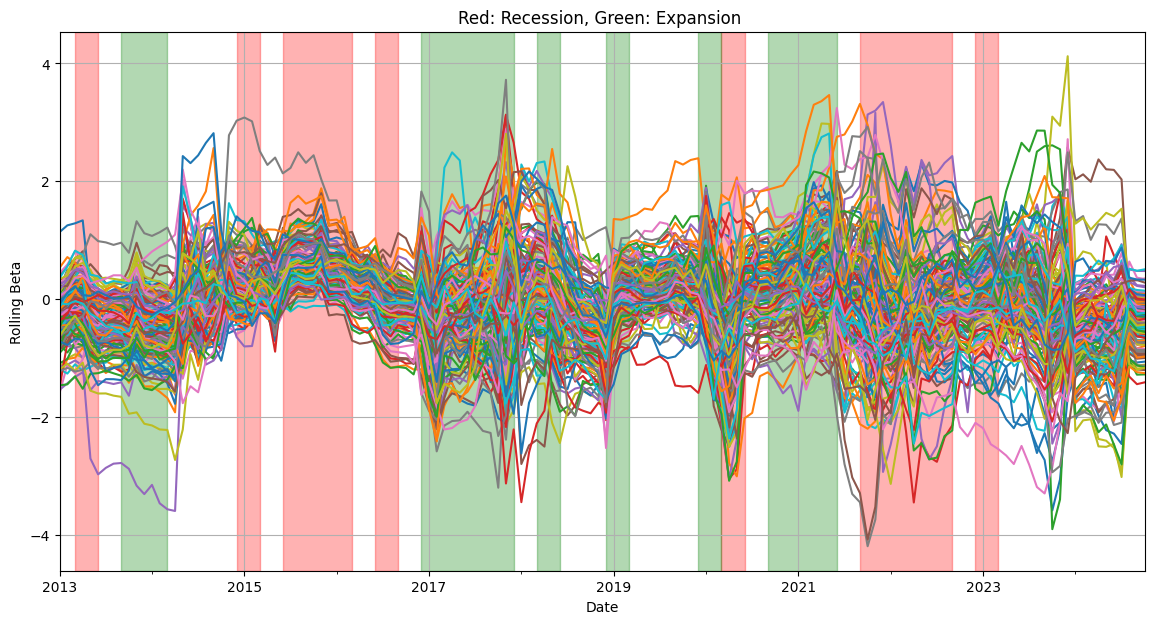

In [8]:
fig, ax = plt.subplots(figsize=(14, 7))

nsoes_betas.plot(ax=ax, label="5-Year Rolling Beta of SOEs")

# Shade recession periods (red):
in_recession = False
start_date_rec = None
for date, is_rec in keqiang_index['recession'].items():
    if is_rec and not in_recession:
        start_date_rec = date  # begin a new recession period
        in_recession = True
    elif not is_rec and in_recession:
        ax.axvspan(start_date_rec, date, color='red', alpha=0.3)
        in_recession = False
# Shade until the end if still in recession:
if in_recession:
    ax.axvspan(start_date_rec, keqiang_index.index[-1], color='red', alpha=0.3)
    
# Shade expansion periods (green):
in_expansion = False
start_date_exp = None
for date, is_exp in keqiang_index['expansion'].items():
    if is_exp and not in_expansion:
        start_date_exp = date  # begin a new expansion period
        in_expansion = True
    elif not is_exp and in_expansion:
        ax.axvspan(start_date_exp, date, color='green', alpha=0.3)
        in_expansion = False
# Shade until the end if still in expansion:
if in_expansion:
    ax.axvspan(start_date_exp, keqiang_index.index[-1], color='green', alpha=0.3)

# Final plot settings
ax.set_xlabel("Date")
ax.set_ylabel("Rolling Beta")
ax.set_title("Red: Recession, Green: Expansion ")
ax.legend()
plt.grid(True)

ax.legend_.remove()  # Remove legend

output_path = r"C:\Users\hp\Favorites\Desktop\Thesis\Graphs\fig3.4.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

# Second regression dataframe

In [9]:
lm1 = pd.merge(soes_betas, keqiang_index, left_index=True, right_index=True, how="inner")
lm1 = lm1.drop(columns=["Keqiang Index", "recession", "expansion", "neutral"])
lm2 = pd.merge(nsoes_betas, keqiang_index, left_index=True, right_index=True, how="inner")
lm2 = lm2.drop(columns=["Keqiang Index"])

df = pd.concat([lm1, lm2], axis=1)
print(df)

            exc_000021.SZ  exc_000027.SZ  exc_000059.SZ  exc_000060.SZ  \
2013-03-31      -0.060517       0.112602      -0.434302       0.443042   
2013-06-30      -1.153671       0.044536      -0.881556       0.009556   
2013-09-30      -0.921293       0.096662      -0.809555       0.145513   
2013-12-31      -1.234155       0.099137      -0.625742      -0.274149   
2014-03-31      -1.251221       0.065940      -0.775364      -0.360336   
2014-06-30       1.098367       0.414080       0.003371       1.056567   
2014-09-30       0.646348       0.466281       0.471394       0.351950   
2014-12-31       0.933210       0.312976       0.409649       0.094992   
2015-03-31       0.943455       0.416155      -0.194226       0.144295   
2015-06-30       0.459618       0.135349       0.196627       0.194531   
2015-09-30       0.815153       0.317594       0.595131       0.650581   
2015-12-31       0.936455       0.308182       0.206597       0.419090   
2016-03-31       0.780877       0.0530

In [10]:
file_path = r"C:\Users\hp\Favorites\Desktop\Thesis\All Chinese SOEs.xlsx"
soes = pd.read_excel(file_path, engine="openpyxl")  
soes = soes[["Identifier", "GICS Sector Name"]]

file_path = r"C:\Users\hp\Favorites\Desktop\Thesis\All Chinese non SOEs.xlsx"
nsoes = pd.read_excel(file_path, engine="openpyxl")  
nsoes = nsoes[["Identifier", "GICS Sector Name"]]

sectors = pd.concat([soes, nsoes])
sectors['Identifier'] = sectors['Identifier'].astype(str)

print(sectors)

    Identifier        GICS Sector Name
0    601398.SS              Financials
1    600519.SS        Consumer Staples
2    601288.SS              Financials
3    600941.SS  Communication Services
4    601939.SS              Financials
..         ...                     ...
629  000826.SZ             Industrials
630  600804.SS  Communication Services
631  603377.SS  Consumer Discretionary
632  300594.SZ             Industrials
633  300630.SZ             Health Care

[1117 rows x 2 columns]


In [11]:
macro = df[['recession', 'expansion', 'neutral']]
firm_columns = df.columns[:124]  # first 124 columns = firm betas
long_df = df[firm_columns].reset_index().melt(id_vars='index', var_name='firm', value_name='beta')
long_df.rename(columns={'index': 'Date'}, inplace=True)
long_df['SOE'] = long_df['firm'].apply(lambda x: 1 if firm_columns.get_loc(x) < 81 else 0)
long_df.set_index('Date', inplace=True)
long_df = long_df.merge(macro, left_index=True, right_index=True, how='left')
long_df['recession_x_SOE'] = long_df['recession'] * long_df['SOE']
long_df['expansion_x_SOE'] = long_df['expansion'] * long_df['SOE']
long_df = long_df.reset_index()  # temporarily reset index to work with merge
long_df['Identifier'] = long_df['firm'].str.replace('exc_', '', regex=False)
long_df = long_df.merge(sectors, on='Identifier', how='left')
long_df.rename(columns={'GICS Sector Name': 'sector'}, inplace=True)
long_df.set_index('Date', inplace=True)

print(long_df)

                     firm      beta  SOE  recession  expansion  neutral  \
Date                                                                      
2013-03-31  exc_000021.SZ -0.060517    1          1          0        0   
2013-06-30  exc_000021.SZ -1.153671    1          0          0        1   
2013-09-30  exc_000021.SZ -0.921293    1          0          1        0   
2013-12-31  exc_000021.SZ -1.234155    1          0          1        0   
2014-03-31  exc_000021.SZ -1.251221    1          0          0        1   
...                   ...       ...  ...        ...        ...      ...   
2023-06-30  exc_600776.SS  1.390144    0          0          0        1   
2023-09-30  exc_600776.SS  1.293859    0          0          0        1   
2023-12-31  exc_600776.SS  3.152046    0          0          0        1   
2024-06-30  exc_600776.SS -0.384728    0          0          0        1   
2024-09-30  exc_600776.SS -0.627935    0          0          0        1   

            recession_x_

# Pooled OLS

In [12]:
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from statsmodels.iolib.summary2 import summary_col

# Step 1: Fit models with standard OLS 
model1 = smf.ols('beta ~ recession + expansion + SOE + recession_x_SOE + expansion_x_SOE', data=long_df).fit()
model2 = smf.ols('beta ~ recession + expansion + SOE + recession_x_SOE + expansion_x_SOE + C(sector)', data=long_df).fit()

# Step 2: Stargazer summary
stargazer = Stargazer([model1, model2])
stargazer.title("Regression Results: Effect of SOE and Macro Conditions on Beta")
stargazer.custom_columns(["Model 1", "Model 2"], [1, 1])

main_vars = ['Intercept', 'SOE', 'recession', 'expansion', 'recession_x_SOE', 'expansion_x_SOE']
stargazer.rename_covariates({
    'recession_x_SOE': 'recession x SOE',
    'expansion_x_SOE': 'expansion x SOE',
    'C(sector)[T.Consumer Staples]': 'Consumer Staples',
    'C(sector)[T.Energy]': 'Energy',
    'C(sector)[T.Financials]': 'Financials',
    'C(sector)[T.Health Care]': 'Health Care',
    'C(sector)[T.Industrials]': 'Industrials',
    'C(sector)[T.Information Technology]': 'Information Technology',
    'C(sector)[T.Materials]': 'Materials',
    'C(sector)[T.Real Estate]': 'Real Estate',
    'C(sector)[T.Utilities]': 'Utilities'
})
sector_vars = [var for var in model2.params.index if 'C(sector)' in var]
stargazer.covariate_order(main_vars + sector_vars)

# Step 3: Print LaTeX output
latex_table = stargazer.render_latex()
print("===== LaTeX Table Output =====\n")
print(latex_table)

# Step 4: summary_col table
results_table = summary_col(
    [model1, model2],
    stars=True,
    float_format='%0.4f',
    model_names=['Model 1', 'Model 2'],
    info_dict={'N': lambda x: f"{int(x.nobs)}"},
    regressor_order=[
        'Intercept', 'recession', 'expansion', 'SOE',
        'recession_x_SOE', 'expansion_x_SOE'
    ]
)
print("===== summary_col Table Output =====")
print(results_table)

# Step 5: Full model summaries
print("\n===== Full statsmodels Summary: Model 1 =====")
print(model1.summary())

print("\n===== Full statsmodels Summary: Model 2 =====")
print(model2.summary())


===== LaTeX Table Output =====

\begin{table}[!htbp] \centering
  \caption{Regression Results: Effect of SOE and Macro Conditions on Beta}
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{2}{c}{\textit{Dependent variable: beta}} \
\cr \cline{2-3}
\\[-1.8ex] & \multicolumn{1}{c}{Model 1} & \multicolumn{1}{c}{Model 2}  \\
\\[-1.8ex] & (1) & (2) \\
\hline \\[-1.8ex]
 Intercept & -0.043$^{**}$ & 0.039$^{}$ \\
& (0.021) & (0.035) \\
 SOE & -0.010$^{}$ & 0.002$^{}$ \\
& (0.027) & (0.026) \\
 recession & 0.055$^{}$ & 0.055$^{}$ \\
& (0.036) & (0.035) \\
 expansion & 0.031$^{}$ & 0.031$^{}$ \\
& (0.036) & (0.035) \\
 recession x SOE & -0.013$^{}$ & -0.013$^{}$ \\
& (0.045) & (0.044) \\
 expansion x SOE & -0.079$^{*}$ & -0.079$^{*}$ \\
& (0.045) & (0.044) \\
 Consumer Staples & & -0.220$^{***}$ \\
& & (0.042) \\
 Energy & & -0.139$^{***}$ \\
& & (0.046) \\
 Financials & & -0.152$^{***}$ \\
& & (0.056) \\
 Health Care & & -0.232$^{***}$ \\
& & (0.044) \\

# Pooled OLS with Clustered Standard Errors at firm-level

In [18]:
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from statsmodels.iolib.summary2 import summary_col

# Firm-level clustering
cluster_kwargs = {'cov_type': 'cluster', 'cov_kwds': {'groups': long_df['firm']}}

# Model 1: SOE only
model1 = smf.ols('beta ~ SOE', data=long_df).fit(**cluster_kwargs)

# Model 2: SOE + sector fixed effects
model2 = smf.ols('beta ~ SOE + C(sector)', data=long_df).fit(**cluster_kwargs)

# Model 3: Baseline with macro conditions and interactions
model3 = smf.ols('beta ~ recession + expansion + SOE + recession_x_SOE + expansion_x_SOE', data=long_df).fit(**cluster_kwargs)

# Model 4: Model 3 + sector fixed effects
model4 = smf.ols('beta ~ recession + expansion + SOE + recession_x_SOE + expansion_x_SOE + C(sector)', data=long_df).fit(**cluster_kwargs)

# === Stargazer Table ===
stargazer = Stargazer([model1, model2, model3, model4])
stargazer.title("Regression Results: Effect of SOE and Macro Conditions on Beta (Firm-Level Clustered SEs)")
stargazer.custom_columns(["Model 1", "Model 2", "Model 3", "Model 4"], [1, 1, 1, 1])

main_vars = ['Intercept', 'SOE', 'recession', 'expansion', 'recession_x_SOE', 'expansion_x_SOE']
stargazer.rename_covariates({
    'recession_x_SOE': 'recession x SOE',
    'expansion_x_SOE': 'expansion x SOE',
    'C(sector)[T.Consumer Staples]': 'Consumer Staples',
    'C(sector)[T.Energy]': 'Energy',
    'C(sector)[T.Financials]': 'Financials',
    'C(sector)[T.Health Care]': 'Health Care',
    'C(sector)[T.Industrials]': 'Industrials',
    'C(sector)[T.Information Technology]': 'Information Technology',
    'C(sector)[T.Materials]': 'Materials',
    'C(sector)[T.Real Estate]': 'Real Estate',
    'C(sector)[T.Utilities]': 'Utilities'
})
sector_vars = [var for var in model4.params.index if 'C(sector)' in var]
stargazer.covariate_order(main_vars + sector_vars)

# Print LaTeX table
latex_table = stargazer.render_latex()
print("===== LaTeX Table Output =====\n")
print(latex_table)

# === summary_col Table ===
results_table = summary_col(
    [model1, model2, model3, model4],
    stars=True,
    float_format='%0.4f',
    model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4'],
    info_dict={'N': lambda x: f"{int(x.nobs)}"},
    regressor_order=[
        'Intercept', 'SOE', 'recession', 'expansion',
        'recession_x_SOE', 'expansion_x_SOE'
    ]
)

print("===== summary_col Table Output =====")
print(results_table)

# === Full model summaries ===
print("\n===== Full statsmodels Summary: Model 1 =====")
print(model1.summary())

print("\n===== Full statsmodels Summary: Model 2 =====")
print(model2.summary())

print("\n===== Full statsmodels Summary: Model 3 =====")
print(model3.summary())

print("\n===== Full statsmodels Summary: Model 4 =====")
print(model4.summary())


===== LaTeX Table Output =====

\begin{table}[!htbp] \centering
  \caption{Regression Results: Effect of SOE and Macro Conditions on Beta (Firm-Level Clustered SEs)}
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{4}{c}{\textit{Dependent variable: beta}} \
\cr \cline{2-5}
\\[-1.8ex] & \multicolumn{1}{c}{Model 1} & \multicolumn{1}{c}{Model 2} & \multicolumn{1}{c}{Model 3} & \multicolumn{1}{c}{Model 4}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 Intercept & -0.020$^{}$ & 0.061$^{}$ & -0.043$^{}$ & 0.039$^{}$ \\
& (0.030) & (0.041) & (0.035) & (0.044) \\
 SOE & -0.034$^{}$ & -0.022$^{}$ & -0.010$^{}$ & 0.002$^{}$ \\
& (0.037) & (0.027) & (0.040) & (0.032) \\
 recession & & & 0.055$^{}$ & 0.055$^{}$ \\
& & & (0.034) & (0.034) \\
 expansion & & & 0.031$^{}$ & 0.031$^{}$ \\
& & & (0.039) & (0.039) \\
 recession x SOE & & & -0.013$^{}$ & -0.013$^{}$ \\
& & & (0.043) & (0.043) \\
 expansion x SOE & & & -0.079$^{}$ & -0.079$^{}$ \\
&

In [14]:
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from statsmodels.iolib.summary2 import summary_col

# Firm-level clustering
cluster_kwargs = {'cov_type': 'cluster', 'cov_kwds': {'groups': long_df['firm']}}

# Model 1: Baseline with interactions
model1 = smf.ols('beta ~ SOE', data=long_df).fit(**cluster_kwargs)



# === Full model summaries ===
print("\n===== Full statsmodels Summary: Model 1 =====")
print(model1.summary())





===== Full statsmodels Summary: Model 1 =====
                            OLS Regression Results                            
Dep. Variable:                   beta   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.8694
Date:                Tue, 17 Jun 2025   Prob (F-statistic):              0.353
Time:                        12:22:15   Log-Likelihood:                -5727.1
No. Observations:                5704   AIC:                         1.146e+04
Df Residuals:                    5702   BIC:                         1.147e+04
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

# Graphs 

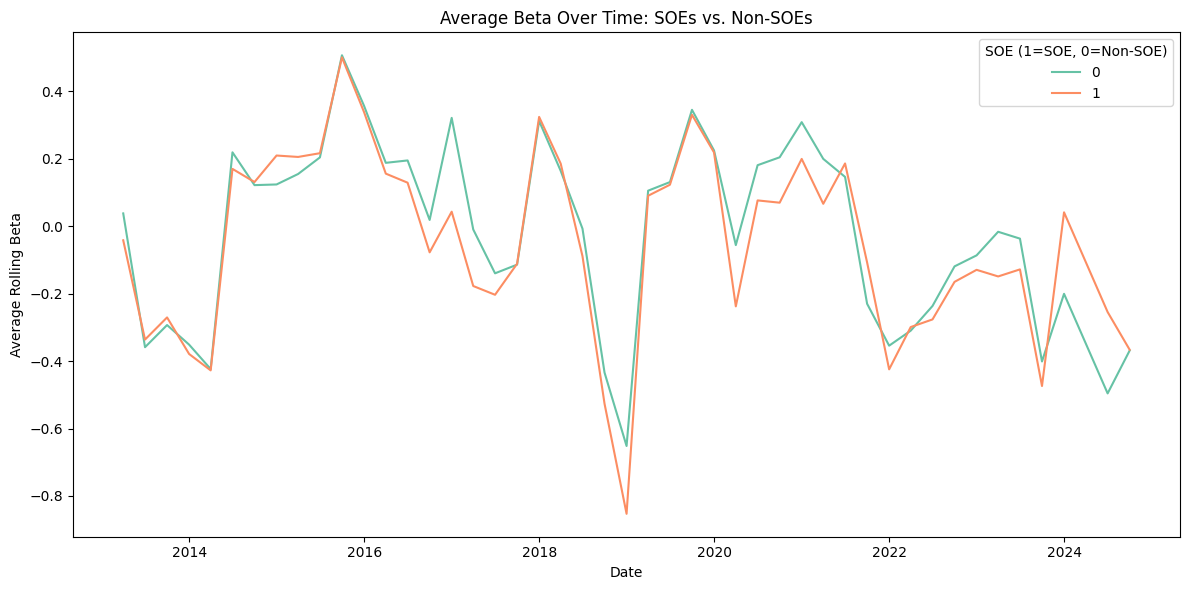

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

long_df = long_df.reset_index()
avg_beta_by_group = long_df.groupby(['Date', 'SOE'])['beta'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_beta_by_group, x='Date', y='beta', hue='SOE', palette='Set2')
plt.title("Average Beta Over Time: SOEs vs. Non-SOEs")
plt.ylabel("Average Rolling Beta")
plt.xlabel("Date")
plt.legend(title="SOE (1=SOE, 0=Non-SOE)")
plt.tight_layout()
plt.show()

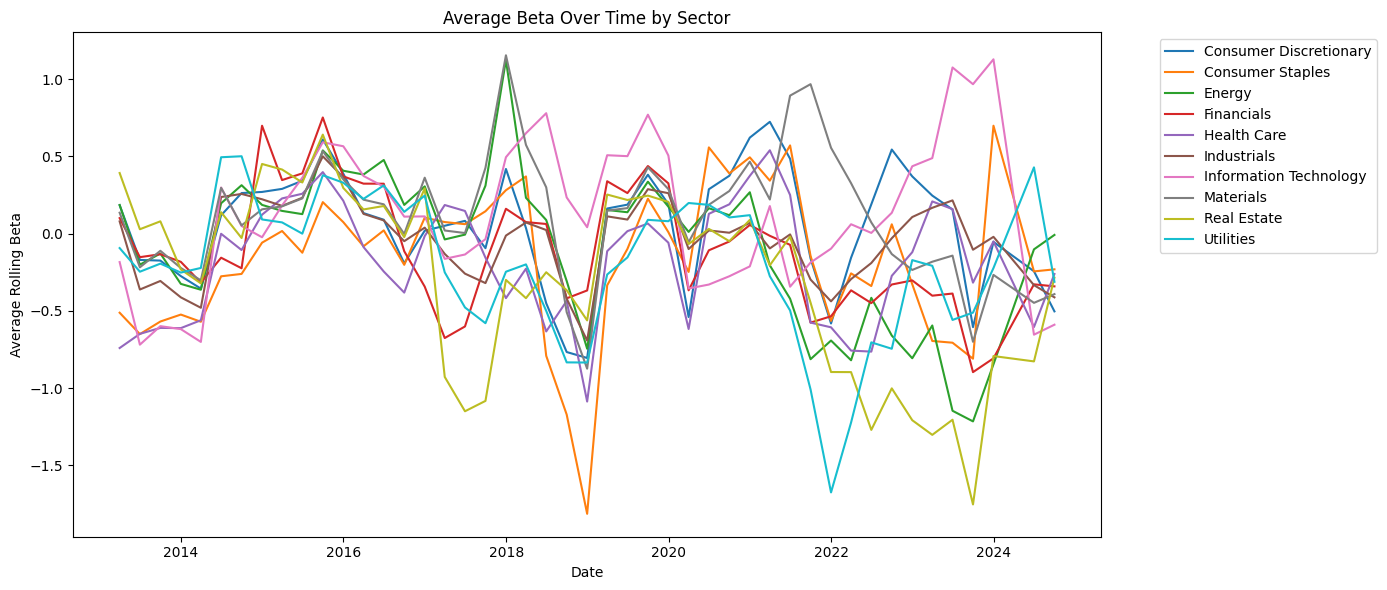

In [16]:
avg_beta_sector = long_df.groupby(['Date', 'sector'])['beta'].mean().reset_index()

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=avg_beta_sector, x='Date', y='beta', hue='sector', legend='full')
plt.title("Average Beta Over Time by Sector")
plt.ylabel("Average Rolling Beta")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

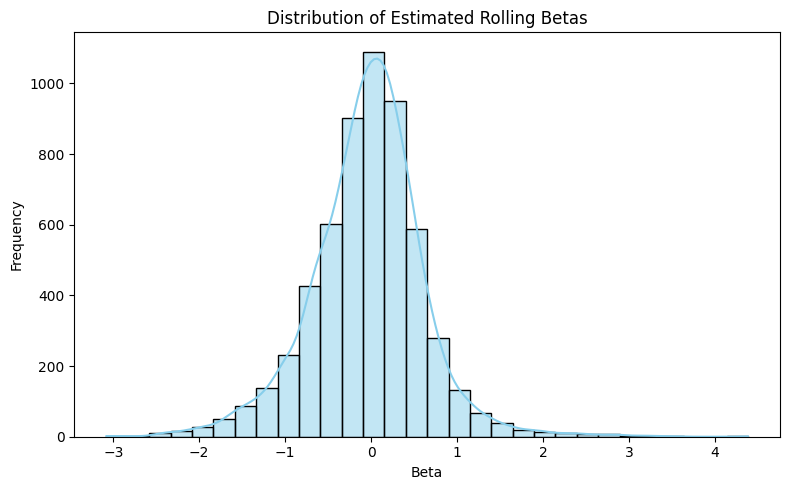

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(long_df['beta'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Estimated Rolling Betas")
plt.xlabel("Beta")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()